In [8]:
%matplotlib inline
import os
os.environ["OMP_NUM_THREADS"] = "2"  # noqa

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.neural_network as nn
from typhon.files import FileSet, NetCDF4
from typhon.geographical import sea_mask
from typhon.plots import binned_statistic, heatmap, styles, worldmap
from typhon.retrieval import SPAREICE
import xarray as xr

plt.style.use(styles('typhon'))

In [ ]:
odata = NetCDF4().read("spareice_training_data.nc")
odata = odata.dropna(dim="collocation")

good = odata["MHS_2C-ICE/2C-ICE/ice_water_path_number"] > 11
good &= odata["MHS_2C-ICE/2C-ICE/ice_water_path_std"] \
        / odata["MHS_2C-ICE/2C-ICE/ice_water_path_mean"] < 0.5
tdata = odata.sel(collocation=[])
tdata["sea_mask"] = "collocation", sea_mask(
    tdata.lat, tdata.lon, "land_water_mask_5min.png"
)

[-90 -75 -60 -45 -30 -15   0  15  30  45  60  75]
split into 12 bins
Reduce 67225 to 20000
Reduce 108479 to 20000
Reduce 83406 to 20000
Reduce 49272 to 20000
Reduce 30290 to 20000
Reduce 55050 to 20000
Reduce 29256 to 20000
Reduce 14791 to 14791
Reduce 20062 to 20000
Reduce 24105 to 20000
Reduce 31364 to 20000
Reduce 19431 to 19431


(234222, 224880)

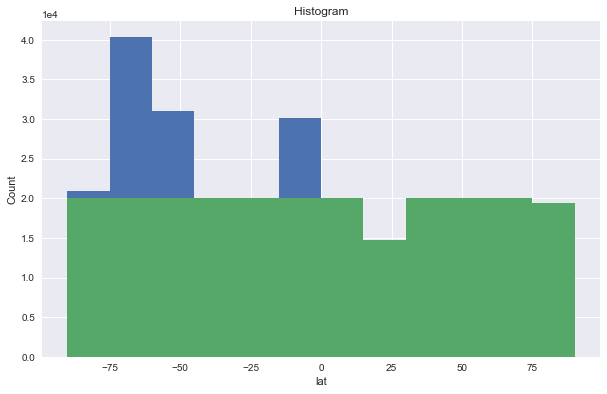

In [35]:
odata = NetCDF4().read("spareice_training_data.nc")
odata = odata.dropna(dim="collocation")

good = odata["MHS_2C-ICE/2C-ICE/ice_water_path_number"] > 11
good &= odata["MHS_2C-ICE/2C-ICE/ice_water_path_std"] \
    / odata["MHS_2C-ICE/2C-ICE/ice_water_path_mean"] < 0.5
tdata = odata.sel(collocation=good)

def balance(data, lat_bin, bin_points):
    bins = np.arange(-90, 90, lat_bin)
    print(bins)
    balanced_data = []
    rest_data = []
    print(f"split into {bins.size} bins")
    for bin_left in bins:
        mask = (bin_left <= data.lat.values) & (data.lat.values < bin_left + lat_bin)
        current_bin_points = mask.sum()
        wanted_bin_points = bin_points if bin_points <= current_bin_points else current_bin_points
        bin_points_indices = mask.nonzero()[0]
        print(f"Reduce {current_bin_points} to {wanted_bin_points}")
        selected_indices = np.random.choice(bin_points_indices, wanted_bin_points, replace=False)
        balanced_data.append(data.isel(collocation=selected_indices))
        rest_indices = np.setdiff1d(np.arange(wanted_bin_points), selected_indices, assume_unique=True)
        rest_data.append(data.isel(collocation=rest_indices))
        
    return xr.concat(balanced_data, dim="collocation"), xr.concat(rest_data, dim="collocation")

bin_width = 15
bdata, rdata  = balance(tdata, bin_width, 20_000)
rdata.lat.plot.hist(bins=180 // bin_width, range=[-90, 90])
bdata.lat.plot.hist(bins=180 // bin_width, range=[-90, 90])
bdata.collocation.size, rdata.collocation.size

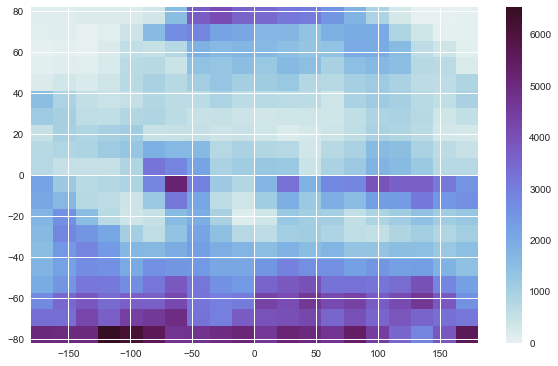

In [80]:
from typhon.plots import worldmap

scat = heatmap(tdata.lon.values, tdata.lat.values, bisectrix=False, cmap="density")
plt.colorbar(scat)

In [61]:
from importlib import import_module

def import_class_from_string(module_name, class_name):
    from importlib import import_module
    mod = import_module(module_name)
    klass = getattr(mod, class_name)
    return klass

for name, model in spareice.retrieval.estimator.steps:
    module_name = type(model).__module__
    class_name = type(model).__name__
    print(module_name, class_name)
    print(import_class_from_string(module_name, class_name))



sklearn.preprocessing.data RobustScaler
<class 'sklearn.preprocessing.data.RobustScaler'>
sklearn.neural_network.multilayer_perceptron MLPRegressor
<class 'sklearn.neural_network.multilayer_perceptron.MLPRegressor'>


In [62]:
_pipeline_from_dict(_pipeline_to_dict(spareice.retrieval.estimator))

[['scaler',
  RobustScaler(copy=True, quantile_range=[15, 85], with_centering=True,
         with_scaling=True)],
 ['estimator',
  MLPRegressor(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
         beta_2=0.999, early_stopping=False, epsilon=1e-08,
         hidden_layer_sizes=[15, 10, 3], learning_rate='constant',
         learning_rate_init=0.001, max_iter=3500, momentum=0.9,
         nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
         solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
         warm_start=False)]]

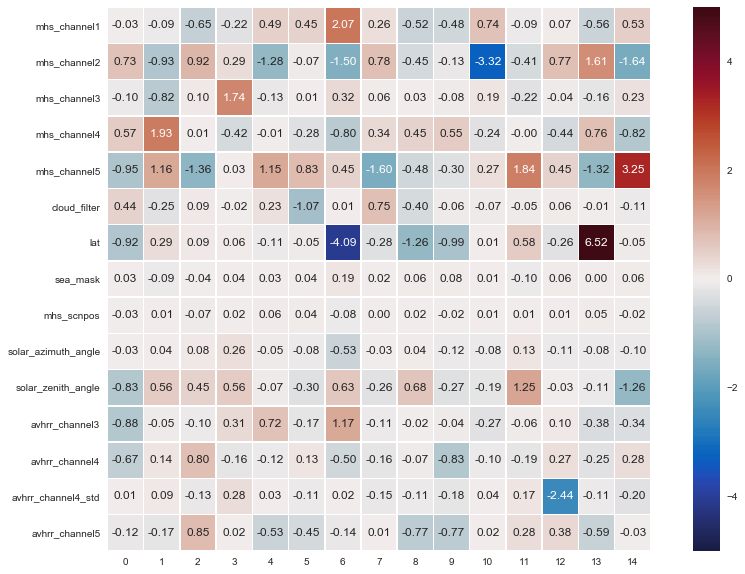

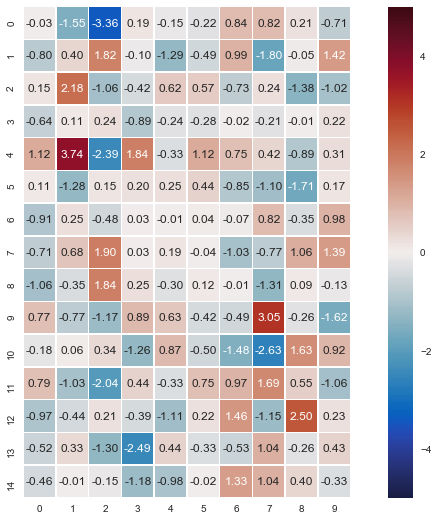

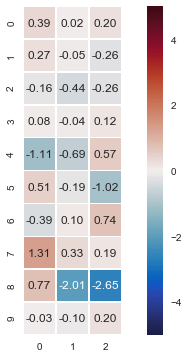

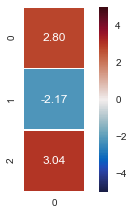

In [27]:
def show_weights(experiment, vmin=-5, vmax=5):
    import seaborn as sns
    sns.set()
    
    spareice = SPAREICE(file=f"experiments/{experiment}/spareice.json")
    layers = spareice.retrieval.estimator.steps[-1][1].coefs_
    
    
    for l, layer in enumerate(layers):
        factor = (layer.size / (15*15))**(0.25)
        f, axes = plt.subplots(figsize=(15*factor, 10*factor))
        weights = pd.DataFrame(layer)
        if l == 0:
            weights.index = spareice.retrieval.parameter["inputs"]

        # Draw a heatmap with the numeric values in each cell
        sns.heatmap(
            weights, annot=True, fmt=".2f", linewidths=.5, ax=axes, 
            square=True, cmap="difference", center=0, vmin=vmin, vmax=vmax)
        
show_weights("with_sea_mask")

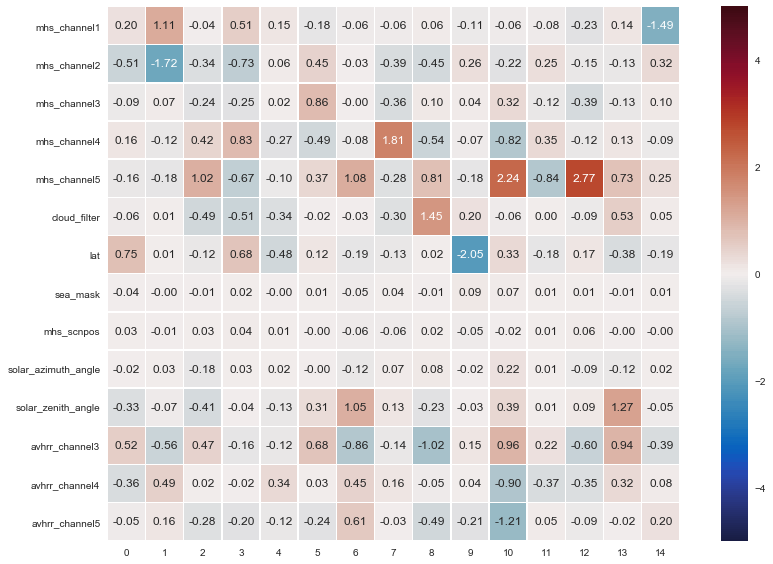

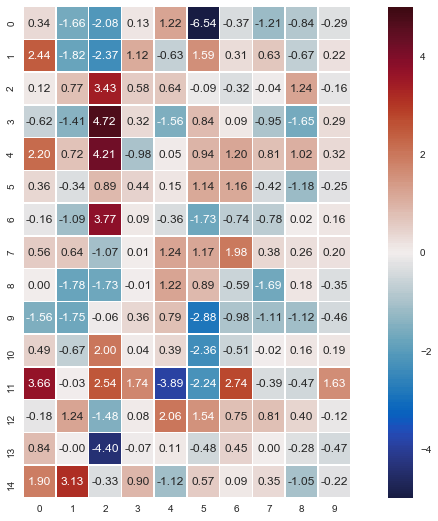

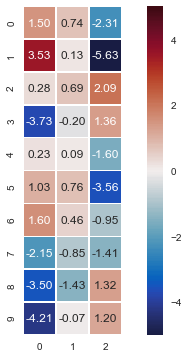

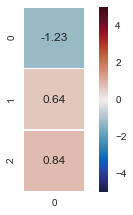

In [28]:
show_weights("without_avhrr_std")

(array([  32.,  226.,  645., 1149., 1553., 2788., 4452., 5479., 5683.,
        4781., 3888., 3016., 2162.,  965.,  111.]),
 array([-1.19083245, -0.83611462, -0.48139679, -0.12667896,  0.22803888,
         0.58275671,  0.93747454,  1.29219237,  1.6469102 ,  2.00162803,
         2.35634586,  2.7110637 ,  3.06578153,  3.42049936,  3.77521719,
         4.12993502]),
 <a list of 15 Patch objects>)

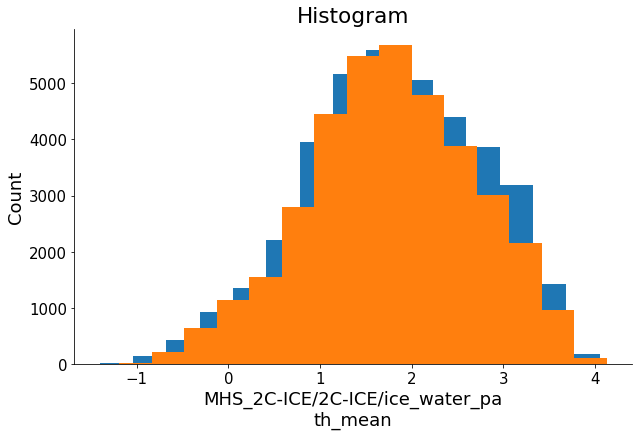

In [48]:
np.log10(
    bdata.isel(collocation=(bdata.lat<-35)&(bdata.lat>-60))["MHS_2C-ICE/2C-ICE/ice_water_path_mean"]
).plot.hist(bins=15)
np.log10(
    bdata.isel(collocation=(bdata.lat>35)&(bdata.lat<60))["MHS_2C-ICE/2C-ICE/ice_water_path_mean"]
).plot.hist(bins=15)

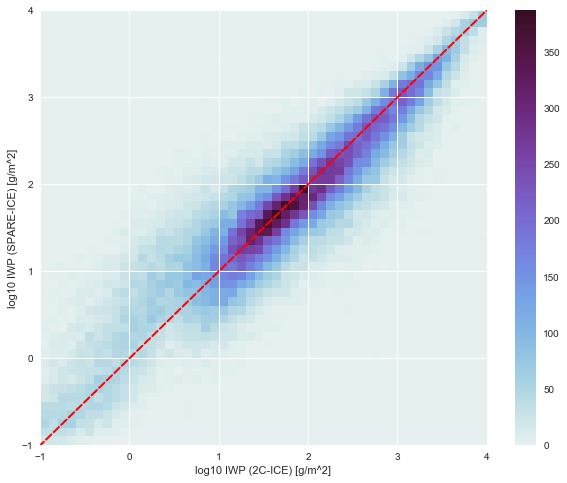

In [21]:
experiment = "test"
lsm = is_over_sea(bdata.lat, bdata.lon, "land_water_mask_5min.png")
train_data, test_data = SPAREICE.split_data(bdata.isel(collocation=lsm))

spareice_iwp = spareice.retrieve(
    test_data, from_collocations=True, as_log10=True
)
test_iwp = spareice.get_targets(test_data)

fig, ax = plt.subplots(figsize=(10, 8))
scat = heatmap(
    test_iwp["iwp_log10"].values,
    spareice_iwp["iwp_log10"].values,
    bins=50, range=[[-1, 4], [-1, 4]],
    cmap="density"
)
ax.set_xlabel("log10 IWP (2C-ICE) [g/m^2]")
ax.set_ylabel("log10 IWP (SPARE-ICE) [g/m^2]")
fig.colorbar(scat)

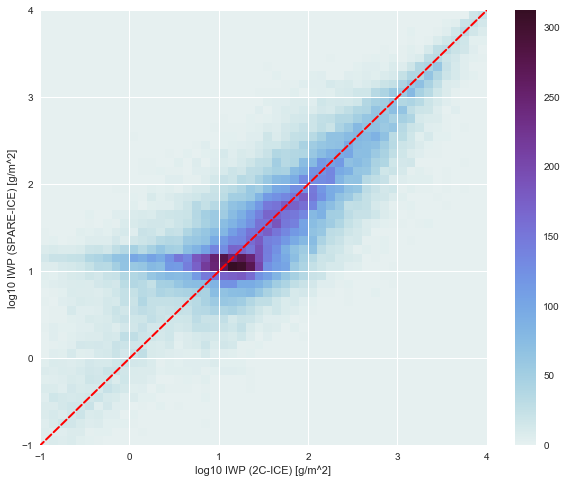

In [22]:
experiment = "test"
lsm = is_over_sea(bdata.lat, bdata.lon, "land_water_mask_5min.png")
train_data, test_data = SPAREICE.split_data(bdata.isel(collocation=~lsm))

spareice_iwp = spareice.retrieve(
    test_data, from_collocations=True, as_log10=True
)
test_iwp = spareice.get_targets(test_data)

fig, ax = plt.subplots(figsize=(10, 8))
scat = heatmap(
    test_iwp["iwp_log10"].values,
    spareice_iwp["iwp_log10"].values,
    bins=50, range=[[-1, 4], [-1, 4]],
    cmap="density"
)
ax.set_xlabel("log10 IWP (2C-ICE) [g/m^2]")
ax.set_ylabel("log10 IWP (SPARE-ICE) [g/m^2]")
fig.colorbar(scat)

Plot test results


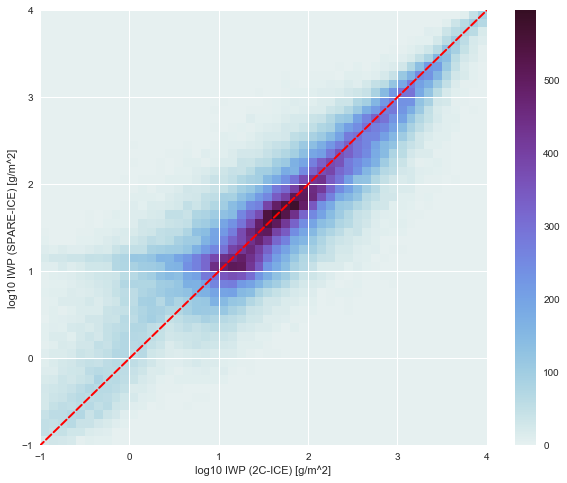

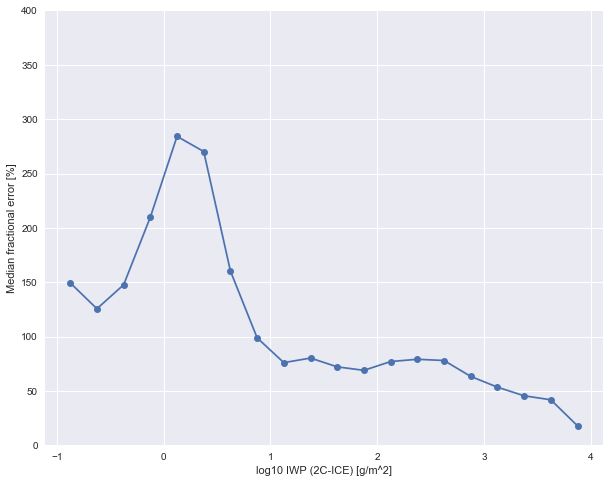

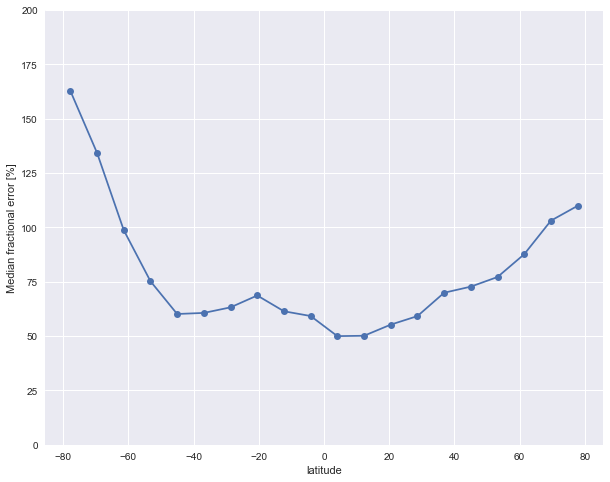

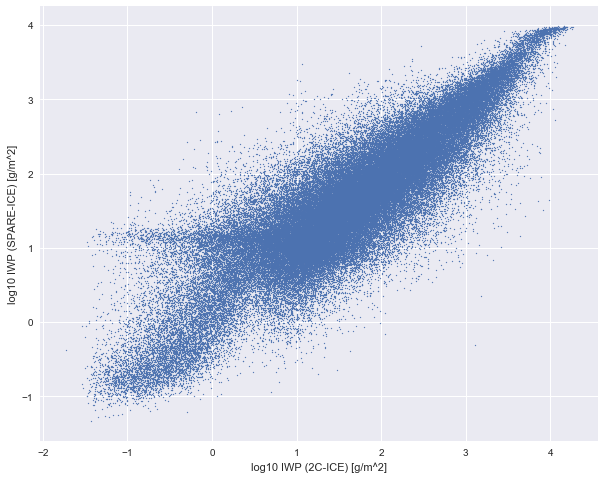

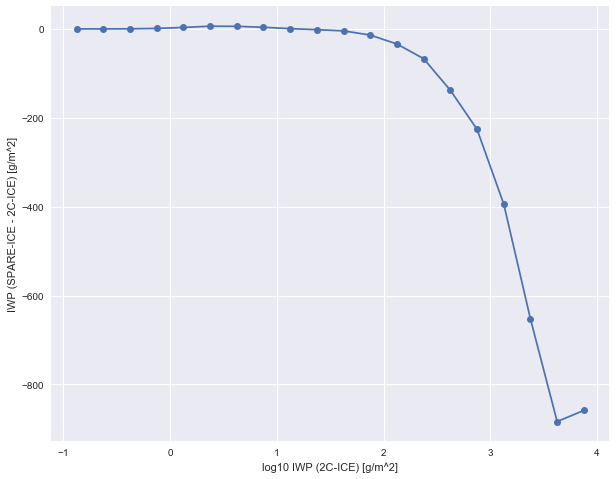

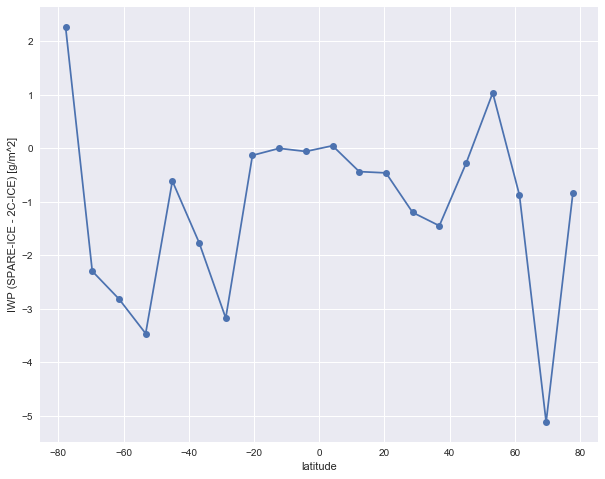

In [11]:
experiment = "test"
train_data, test_data = SPAREICE.split_data(bdata)

spareice_iwp = spareice.retrieve(
    test_data, from_collocations=True, as_log10=True
)
test_iwp = spareice.get_targets(test_data)

fig, ax = plt.subplots(figsize=(10, 8))
scat = heatmap(
    test_iwp["iwp_log10"].values,
    spareice_iwp["iwp_log10"].values,
    bins=50, range=[[-1, 4], [-1, 4]],
    cmap="density"
)
ax.set_xlabel("log10 IWP (2C-ICE) [g/m^2]")
ax.set_ylabel("log10 IWP (SPARE-ICE) [g/m^2]")
fig.colorbar(scat)
fig.savefig(f"plots/{experiment}/2C-ICE-SPAREICE_heatmap.png")

fig, ax = plt.subplots(figsize=(10, 8))
fe = 100*(np.exp(np.abs(np.log(10**spareice_iwp["iwp_log10"].values / 10**test_iwp["iwp_log10"].values))) - 1)
binned_statistic(
    test_iwp["iwp_log10"].values,
    fe, range=[-1, 4], pargs={"marker": "o"}
)
ax.set_xlabel("log10 IWP (2C-ICE) [g/m^2]")
ax.set_ylabel("Median fractional error [%]")
ax.set_ylim([0, 400])
fig.savefig(f"plots/{experiment}/2C-ICE-SPAREICE_mfe.png")

fig, ax = plt.subplots(figsize=(10, 8))
binned_statistic(
    test_data.lat.values,
    fe, pargs={"marker": "o"}
)
ax.set_xlabel("latitude")
ax.set_ylabel("Median fractional error [%]")
ax.set_ylim([0, 200])

fig, ax = plt.subplots(figsize=(10, 8))
scat = plt.scatter(
    test_iwp["iwp_log10"].values,
    spareice_iwp["iwp_log10"].values,
    s=1
)
ax.set_xlabel("log10 IWP (2C-ICE) [g/m^2]")
ax.set_ylabel("log10 IWP (SPARE-ICE) [g/m^2]")
fig.savefig(f"plots/{experiment}/2C-ICE-SPAREICE_scatter.png")

fig, ax = plt.subplots(figsize=(10, 8))
bias = 10**spareice_iwp["iwp_log10"].values - 10**test_iwp["iwp_log10"].values
binned_statistic(
    test_iwp["iwp_log10"].values,
    bias, range=[-1, 4], pargs={"marker": "o"}
)
ax.set_xlabel("log10 IWP (2C-ICE) [g/m^2]")
ax.set_ylabel("IWP (SPARE-ICE - 2C-ICE) [g/m^2]")
#ax.set_ylim([0, 400])
fig.savefig(f"plots/{experiment}/2C-ICE-SPAREICE_bias.png")

fig, ax = plt.subplots(figsize=(10, 8))
binned_statistic(
    test_data.lat.values,
    bias, pargs={"marker": "o"}
)
ax.set_xlabel("latitude")
ax.set_ylabel("IWP (SPARE-ICE - 2C-ICE) [g/m^2]")
#ax.set_ylim([0, 200])
fig.savefig(f"plots/{experiment}/2C-ICE-SPAREICE_bias_lat.png")

In [9]:
spareice.score(test_data)

0.7802522409190205

(array([0.00000e+00, 0.00000e+00, 1.00210e+04, 4.83640e+04, 1.86857e+05,
        1.34495e+05, 5.42580e+04, 1.54600e+04, 7.50000e+01, 0.00000e+00]),
 array([ 0.,  9., 18., 27., 36., 45., 54., 63., 72., 81., 90.]),
 <a list of 10 Patch objects>)

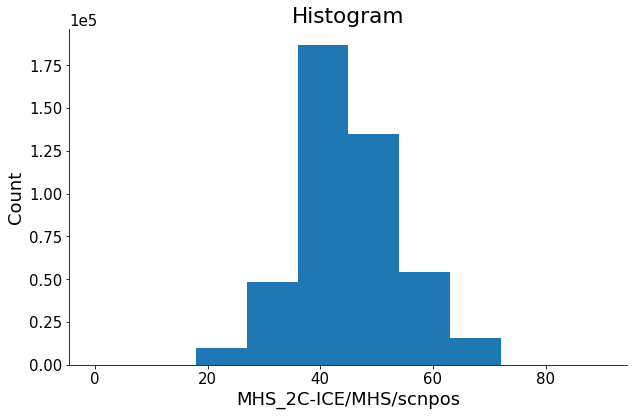

In [4]:
tdata["MHS_2C-ICE/MHS/scnpos"].plot.hist(range=[0, 90])

(array([73197., 58572., 52215., 40342., 28895., 19214., 13537., 19763.,
        30124., 14548., 10914.,  6300.,  8599., 10054., 11420., 13909.,
        16922., 21005.]),
 array([-8.18903979e+01, -7.27914759e+01, -6.36925539e+01, -5.45936320e+01,
        -4.54947100e+01, -3.63957880e+01, -2.72968660e+01, -1.81979440e+01,
        -9.09902199e+00, -9.99999975e-05,  9.09882199e+00,  1.81977440e+01,
         2.72966660e+01,  3.63955880e+01,  4.54945100e+01,  5.45934320e+01,
         6.36923539e+01,  7.27912759e+01,  8.18901979e+01]),
 <a list of 18 Patch objects>)

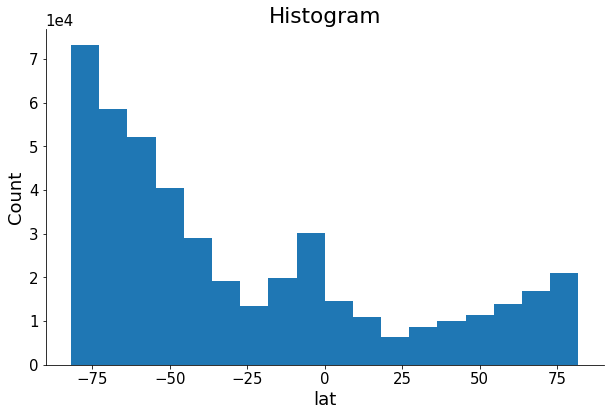

In [5]:
tdata.lat.plot.hist(bins=18)

(array([  1130.,   9594.,  21175.,  30797.,  73098., 116521.,  94587.,
         64618.,  32464.,   5546.]),
 array([-1.81517246, -1.20731576, -0.59945906,  0.00839764,  0.61625435,
         1.22411105,  1.83196775,  2.43982445,  3.04768115,  3.65553786,
         4.26339456]),
 <a list of 10 Patch objects>)

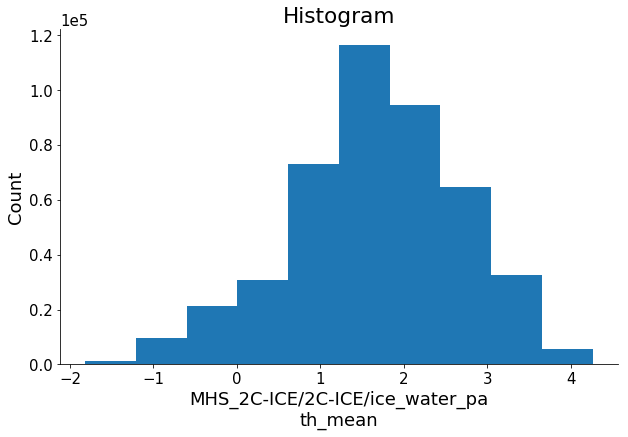

In [6]:
np.log10(tdata["MHS_2C-ICE/2C-ICE/ice_water_path_mean"]).plot.hist()

[-90 -75 -60 -45 -30 -15   0  15  30  45  60  75]
split into 12 bins
Reduce 59294 to 12000
Reduce 95074 to 12000
Reduce 71767 to 12000
Reduce 41507 to 12000
Reduce 24164 to 12000
Reduce 44053 to 12000
Reduce 22495 to 12000
Reduce 11332 to 11332
Reduce 16071 to 12000
Reduce 20156 to 12000
Reduce 26860 to 12000
Reduce 16757 to 12000


(array([12000., 12000., 12000., 12000., 12000., 12000., 12000., 11332.,
        12000., 12000., 12000., 12000.]),
 array([-90., -75., -60., -45., -30., -15.,   0.,  15.,  30.,  45.,  60.,
         75.,  90.]),
 <a list of 12 Patch objects>)

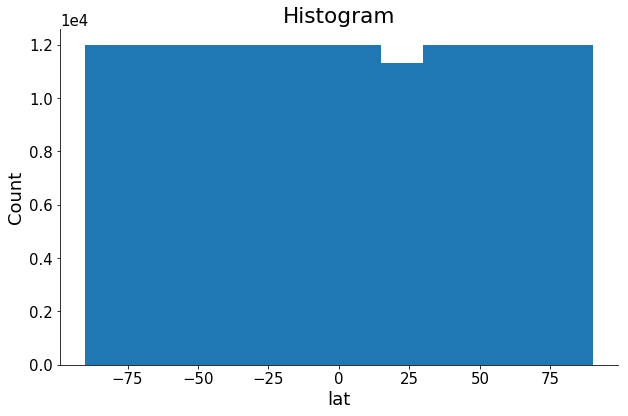

(array([  376.,  3179.,  7155.,  9066., 22320., 37764., 29796., 20126.,
        11107.,  2443.]),
 array([-1.81517246, -1.20731576, -0.59945906,  0.00839764,  0.61625435,
         1.22411105,  1.83196775,  2.43982445,  3.04768115,  3.65553786,
         4.26339456]),
 <a list of 10 Patch objects>)

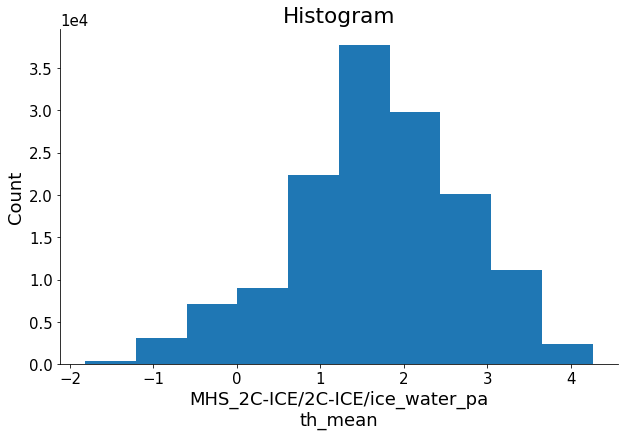

In [8]:
np.log10(bdata["MHS_2C-ICE/2C-ICE/ice_water_path_mean"]).plot.hist()

[SPARE-ICE] Train SPARE-ICE
[SPARE-ICE] Training score: 0.81


Plot test results


(0, 200)

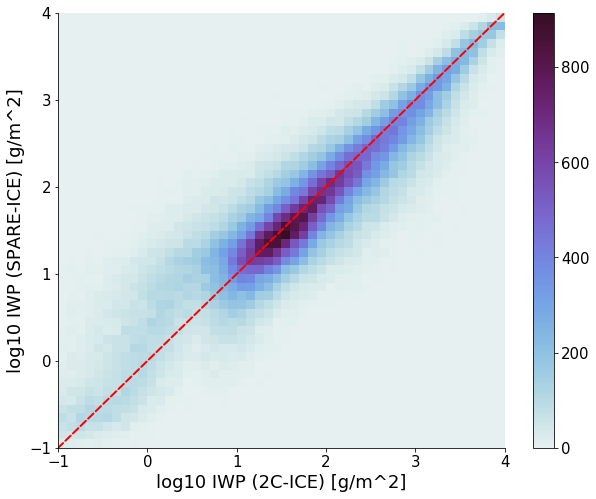

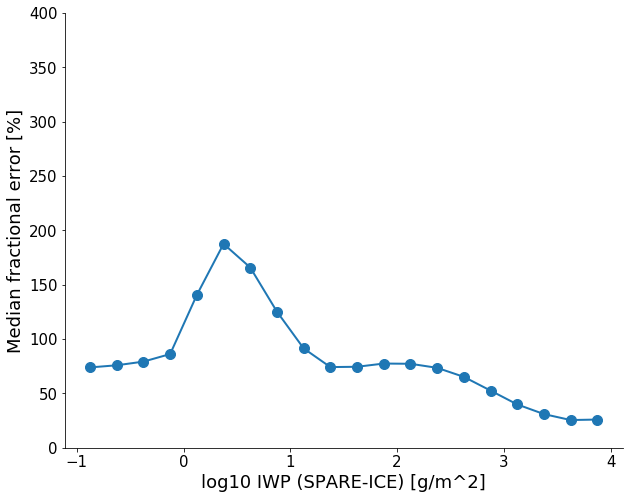

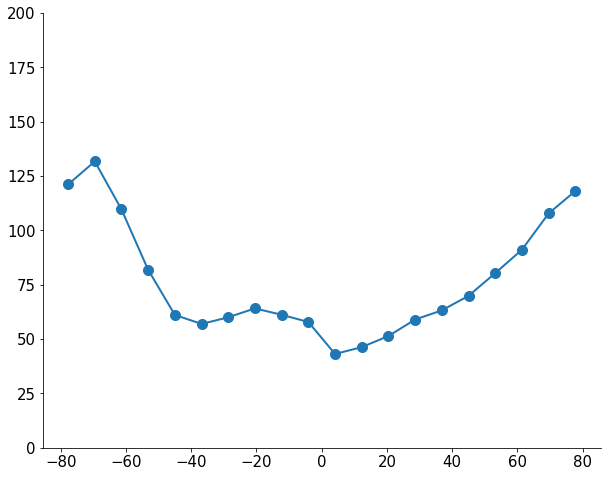

Plot test results


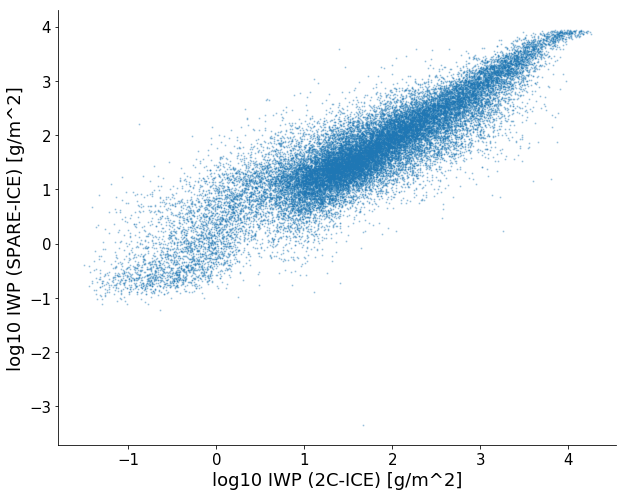

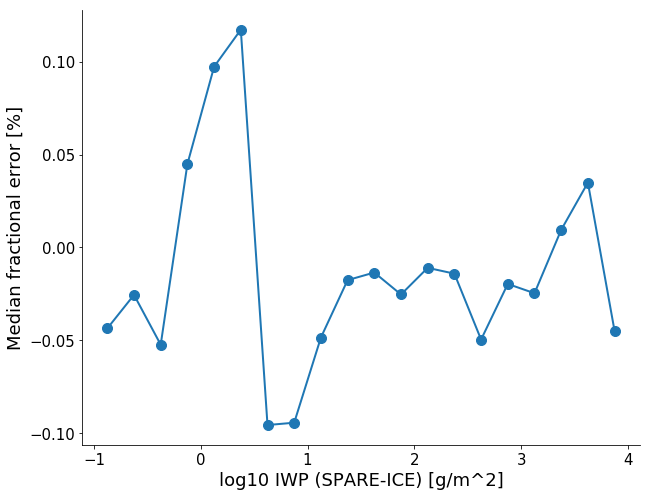

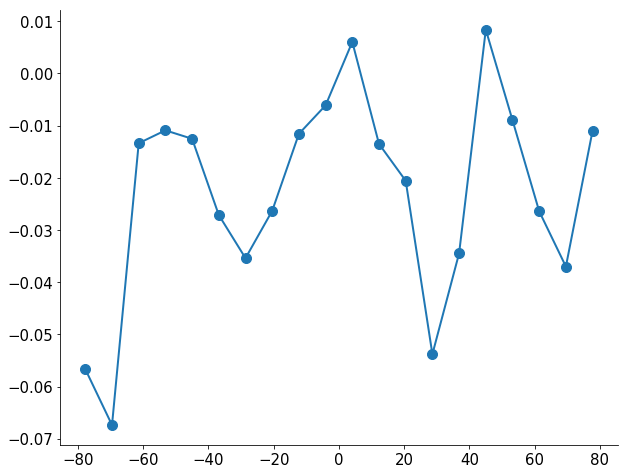

(array([  62.,  188.,  388.,  552.,  763.,  895.,  803., 1138., 2221.,
        3249., 3690., 3238., 2943., 2427., 2043., 1676., 1242.,  747.,
         309.,   93.]),
 array([-1.50943162, -1.22128772, -0.93314382, -0.64499991, -0.35685601,
        -0.06871211,  0.21943179,  0.50757569,  0.79571959,  1.08386349,
         1.37200739,  1.66015129,  1.94829519,  2.23643909,  2.52458299,
         2.81272689,  3.10087079,  3.38901469,  3.67715859,  3.96530249,
         4.25344639]),
 <a list of 20 Patch objects>)

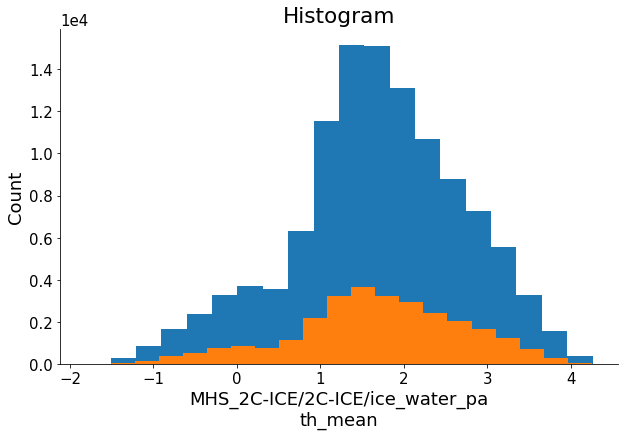

In [20]:
np.log10(train_data["MHS_2C-ICE/2C-ICE/ice_water_path_mean"]).plot.hist(bins=20)
np.log10(test_data["MHS_2C-ICE/2C-ICE/ice_water_path_mean"]).plot.hist(bins=20)

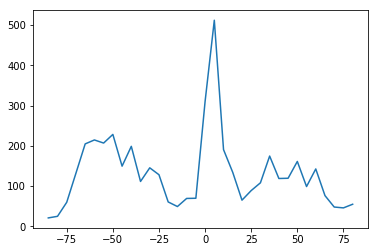

In [38]:
zonal = data.groupby_bins("lat", np.arange(-90, 90, 5)).median()
plt.plot(np.arange(-90, 85, 5), zonal["2C-ICE_ice_water_path_mean"])

/dev/shm/u237002/anaconda36/envs/python36/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")


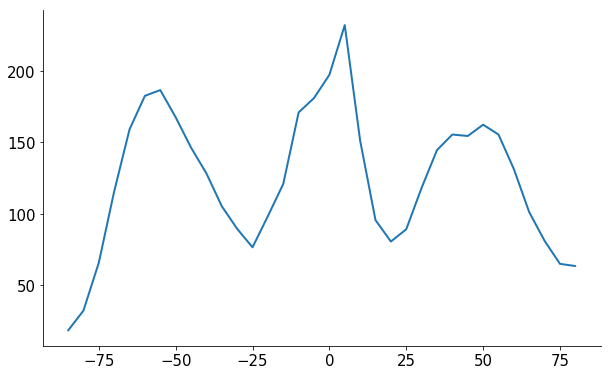

In [12]:
from typhon.files import CloudSat, FileSet, NetCDF4

cloudsat = FileSet(
    name="2C-ICE",
    path="/scratch/uni/u237/data/cloudsat/2C-ICE.P1_R04/{year}/{doy}/"
         "{year}{doy}{hour}{minute}{second}_*.hdf.zip",
    handler=CloudSat(),
    # Each file of CloudSat covers exactly 5933 seconds. Since we state it
    # here, the indexing of files is much faster
    time_coverage="5933 seconds",
    # Load only the fields that we need:
    read_args={
        "fields": ["ice_water_path"],
    },
    max_threads=10,
)

cdata = xr.concat(cloudsat["2007":"2008"], dim="scnline")
NetCDF4().write(cdata, "2C-ICE_2007.nc")
cdata_zonal = cdata.groupby_bins("lat", np.arange(-90, 90, 5)).mean()
plt.plot(np.arange(-90, 85, 5), cdata_zonal["ice_water_path"])
plt.savefig("2C-ICE_zonal_mean.png")

In [24]:
cdata = xr.open_dataset("2C-ICE_2007.nc").load()
cdata

<xarray.Dataset>
Dimensions:         (scnline: 169920097)
Dimensions without coordinates: scnline
Data variables:
    ice_water_path  (scnline) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    lon             (scnline) float64 13.04 13.04 13.03 13.03 13.03 13.03 ...
    lat             (scnline) float64 -0.004093 -0.01376 -0.02343 -0.0331 ...
    time            (scnline) datetime64[ns] 2007-01-01T00:51:42 ...

In [32]:
1169810190 / 169920097

6.884472235205939

In [37]:
from scipy.stats import binned_statistic

lat_bins = np.arange(-90, 85, 5)
zonal, _, _ = binned_statistic(
    cdata.lat.values, cdata.ice_water_path.values, np.nanmean, bins=lat_bins
)

Plot test results


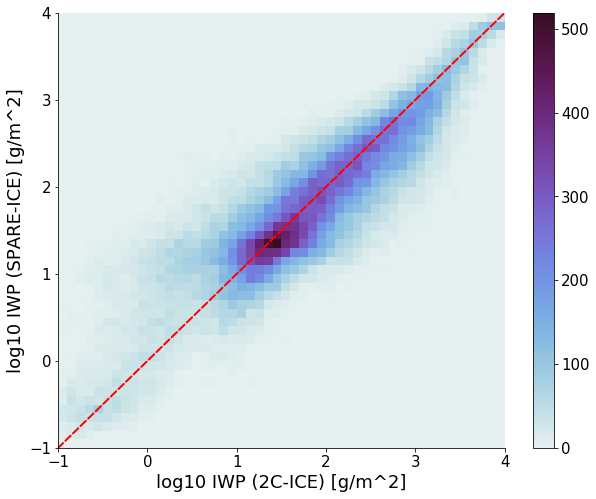

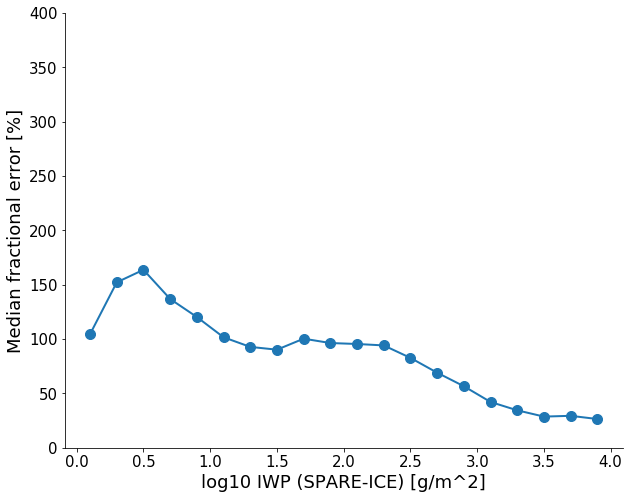

In [40]:
spareice_iwp = spareice.retrieve(
    training_data, from_collocations=True, as_log10=True
)

training_iwp = spareice.get_targets(training_data)

print("Plot test results")
fig, ax = plt.subplots(figsize=(10, 8))
scat = heatmap(
    training_iwp["iwp_log10"].values,
    spareice_iwp["iwp_log10"].values,
    bins=50, range=[[-1, 4], [-1, 4]],
    cmap="density"
)
ax.set_xlabel("log10 IWP (2C-ICE) [g/m^2]")
ax.set_ylabel("log10 IWP (SPARE-ICE) [g/m^2]")
fig.savefig("plots/2C-ICE-SPAREICE_heatmap.png")
fig.colorbar(scat)

fig, ax = plt.subplots(figsize=(10, 8))
fe = 100*(np.exp(np.abs(np.log(10**spareice_iwp["iwp_log10"].values / 10**training_iwp["iwp_log10"].values))) - 1)
binned_statistic(
    spareice_iwp["iwp_log10"].values,
    fe, range=[0, 4], pargs={"marker": "o"}
)
ax.set_xlabel("log10 IWP (SPARE-ICE) [g/m^2]")
ax.set_ylabel("Median fractional error [%]")
ax.set_ylim([0, 400])
fig.savefig("plots/2C-ICE-SPAREICE_mfe.png")

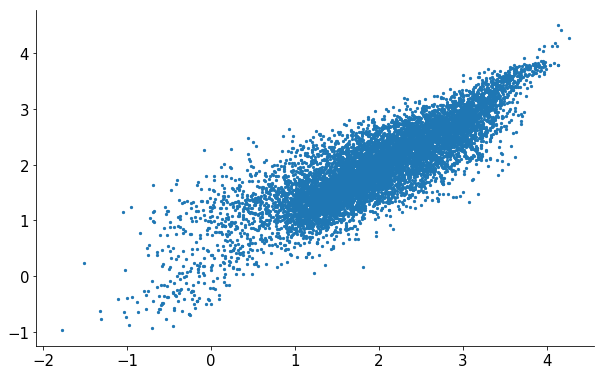

In [34]:
scat = plt.scatter(
    training_iwp["iwp_log10"].values[training_data["AVHRR/Data_btemps_number"].isel(channel=0) > 13],
    spareice_iwp["iwp_log10"].values[training_data["AVHRR/Data_btemps_number"].isel(channel=0) > 13],
    s=5, #cmap="difference"
)
#plt.plot([-1, 4], [-1, 4], c="k", lw=5)
#plt.colorbar(scat)

(array([   41.,   291.,  1022.,  1784.,  5614., 12141., 10320.,  8646.,
         4599.,   804.]),
 array([-1.77731335, -1.17324256, -0.56917177,  0.03489902,  0.63896981,
         1.2430406 ,  1.84711139,  2.45118219,  3.05525298,  3.65932377,
         4.26339456]),
 <a list of 10 Patch objects>)

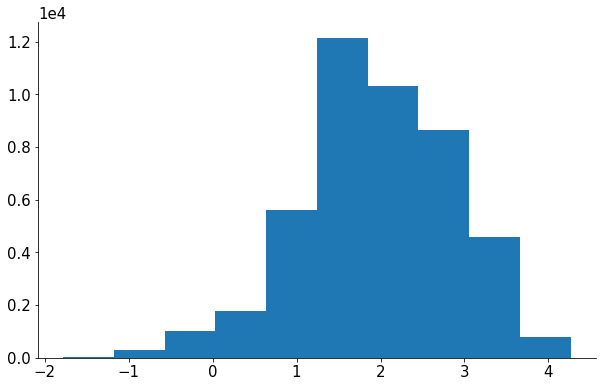

In [14]:
plt.hist(training_iwp["iwp_log10"])

In [7]:
training = NetCDF4().read("spareice_training_data.nc")
training

<xarray.Dataset>
Dimensions:                                          (AVHRR/collocation: 45262, channel: 5, collocation: 45262)
Coordinates:
  * channel                                          (channel) int64 1 2 3 4 5
Dimensions without coordinates: AVHRR/collocation, collocation
Data variables:
    Data_btemps                                      (collocation, channel) float64 ...
    Data_chanqual                                    (collocation, channel) int32 ...
    Data_coldnedt                                    (collocation, channel) int32 ...
    Data_instrtemp                                   (collocation) float64 ...
    Data_qualind                                     (collocation) int32 ...
    Data_scanqual                                    (collocation) int32 ...
    Data_warmnedt                                    (collocation, channel) int32 ...
    lat                                              (collocation) float64 ...
    lon                                   

(array([   41.,   291.,  1022.,  1784.,  5614., 12141., 10320.,  8646.,
         4599.,   804.]),
 array([-1.77731335, -1.17324256, -0.56917177,  0.03489902,  0.63896981,
         1.2430406 ,  1.84711139,  2.45118219,  3.05525298,  3.65932377,
         4.26339456]),
 <a list of 10 Patch objects>)

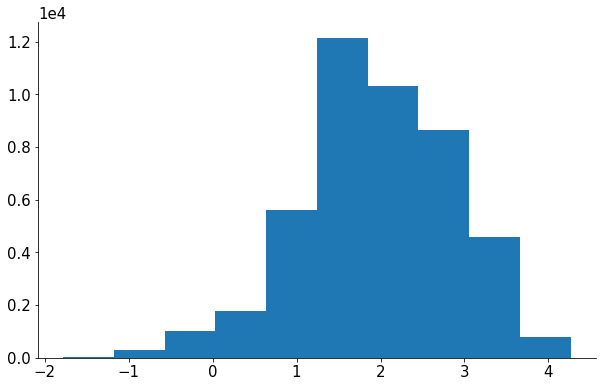

In [9]:
plt.hist(np.log10(training["2C-ICE_ice_water_path_mean"]))

In [27]:
var_coeff = training["AVHRR/Data_btemps_std"].isel(channel=4) / training["AVHRR/Data_btemps_mean"].isel(channel=4)
print(var_coeff)
plt.hist(var_coeff.dropna())

<xarray.DataArray (AVHRR/collocation: 45262)>
array([0.004002, 0.002119, 0.008368, ..., 0.003987, 0.018143, 0.01124 ])
Coordinates:
    channel  int64 5
Dimensions without coordinates: AVHRR/collocation


TypeError: dropna() missing 1 required positional argument: 'dim'